# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Here are the descriptions for the relevant columns:
* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

We will try to predict the cnt column, the total number of bike rentals.

In [79]:
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


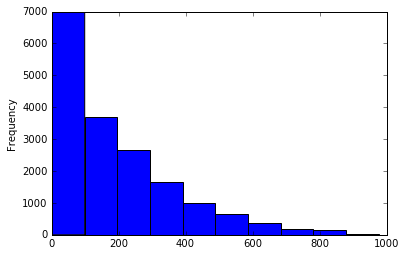

In [80]:
%matplotlib inline

bike_rentals['cnt'].plot.hist()

In [81]:
bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Some hours are related, so we will simplify by grouping them together into labels for morning, afternoon, evening and night.

In [82]:
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4
    if hour >= 6 and hour < 12:
        return 1
    if hour >= 12 and hour < 18:
        return 2
    if hour >= 18 and hour <= 24:
        return 3
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label']

0        4
1        4
2        4
3        4
4        4
5        4
6        1
7        1
8        1
9        1
10       1
11       1
12       2
13       2
14       2
15       2
16       2
17       2
18       3
19       3
20       3
21       3
22       3
23       3
24       4
25       4
26       4
27       4
28       4
29       1
        ..
17349    3
17350    3
17351    3
17352    3
17353    3
17354    3
17355    4
17356    4
17357    4
17358    4
17359    4
17360    4
17361    1
17362    1
17363    1
17364    1
17365    1
17366    1
17367    2
17368    2
17369    2
17370    2
17371    2
17372    2
17373    3
17374    3
17375    3
17376    3
17377    3
17378    3
Name: time_label, Length: 17379, dtype: int64

## Splitting the Data into Train and Test Sets

We will use the mean squared error metric since "cnt" is continous numeric data.

In [83]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression

In [84]:
columns = bike_rentals.columns.drop(['cnt', 'casual', 'dteday', 'registered', 'instant'])

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[columns], train['cnt'])
predictions = lr.predict(test[columns])
mse = mean_squared_error(test['cnt'], predictions)
mse

17721.779049551445

## Decision Tree

In [85]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=1, min_samples_leaf=6, max_depth=20)
dtr.fit(train[columns], train['cnt'])
predictions = dtr.predict(test[columns])
mse = mean_squared_error(test['cnt'], predictions)
mse

2856.1256930229106

## Random Forest

In [86]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=1, min_samples_leaf=2, max_depth=20)
rfr.fit(train[columns], train['cnt'])
predictions = rfr.predict(test[columns])
mse = mean_squared_error(test['cnt'], predictions)
mse

2043.5089344319977

## Generating predictions

As we've seen, the Random Forest Regressor gave us the minimum error. We'll use its predictions.

In [87]:
test['predicted cnt'] = predictions
test.loc[:,['cnt', 'predicted cnt']]

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,cnt,predicted cnt
2,32,19.913333
14,106,143.976667
16,93,89.128333
18,35,62.291667
24,17,66.281667
33,53,47.770000
49,1,2.220238
51,30,30.388333
53,154,174.018333
58,61,65.456667
